In [38]:
import os.path
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import dask
import easygems
import easygems.healpix as egh
from scipy.interpolate import griddata
import matplotlib.colors as mcolors


In [8]:
data_dir = '~/lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5'
t2m_wind_10m_path = os.path.join(data_dir, 'ERA5_monthly.1940-2025.t2m_wind10.nc')
precip_radflx_path = os.path.join(data_dir, 'ERA5_monthly.1940-2025.precip_radflx.nc')

In [13]:
t2m_wind_10m = xr.open_dataset(t2m_wind_10m_path)
t2m = t2m_wind_10m['t2m']
u10 = t2m_wind_10m['u10']
v10 = t2m_wind_10m['v10']
t2m_wind_10m

<xarray.Dataset> Size: 13GB
Dimensions:     (valid_time: 1029, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2025-09-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 16kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 4GB ...
    v10         (valid_time, latitude, longitude) float32 4GB ...
    t2m         (valid_time, latitude, longitude) float32 4GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-27T21:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
precip_radflx = xr.open_dataset(precip_radflx_path)
tp = precip_radflx['tp']
tp

<xarray.DataArray 'tp' (valid_time: 1029, latitude: 721, longitude: 1440)> Size: 4GB
[1068348960 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2025-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 16kB ...
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [ ]:
def map_view(data, var: str, time, bounds=[100,150,15,45]):
    #FOR PLOTTING ICON DATA (NON-REGRIDDED)
    #ALSO PROBABLY BROKEN

    # Step 1: Subset grid to lat/lon region
    if bounds:
        w, e, s, n = bounds
        condition = (
            (data.clon.values >= np.deg2rad(w)) &
            (data.clon.values <= np.deg2rad(e)) &
            (data.clat.values >= np.deg2rad(s)) &
            (data.clat.values <= np.deg2rad(n))
        )
    else:
        condition = True

    indices = np.where(condition)[0]

    # Step 2: Extract coords and data
    clon_subset = data.longitude.values[indices]
    clat_subset = data.latitude.values[indices]
    data_of_interest = data[var].isel(valid_time=time, number=indices).values

    # Convert from radians to degrees
    lon_subset = np.rad2deg(clon_subset)
    lat_subset = np.rad2deg(clat_subset)

    # Step 3: Create regular lat/lon grid
    lon_grid = np.linspace(100, 150, 500)
    lat_grid = np.linspace(15, 45, 300)
    lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)

    # Step 4: Interpolate using griddata
    points = np.column_stack([lon_subset, lat_subset])
    grid_values = griddata(points, data_of_interest, (lon2d, lat2d), method='linear')

    # Step 5: Plot the interpolated grid
    fig, ax = plt.subplots(
        figsize=(10, 6),
        subplot_kw={"projection": ccrs.PlateCarree()},
        constrained_layout=True
    )

    pcm = ax.pcolormesh(
        lon2d, lat2d, grid_values,
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        shading='auto'
    )

    ax.set_extent([100, 150, 15, 45], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linewidth=0.5)
    plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.05, label='Precipitation')
    plt.title('Interpolated Precipitation at Time Step 1000')
    plt.show()

In [ ]:
def worldmap(data, **kwargs):
    #ALSO FOR ICON DATA
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    #plt.title(data['valid_time'][0].values)
    imsh=egh.healpix_show(data, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    fig.colorbar(imsh, label="kg m-2 s-1")

In [39]:
def plot_map(dataset, title, bounds=None):
    
    fig, ax = plt.subplots(
    figsize=(12, 8), facecolor="white", subplot_kw={"projection": ccrs.PlateCarree()}
    )

    norm = mcolors.BoundaryNorm(boundaries=[0,0.5,2,5,10,15,20,30,50], ncolors=256)
   
    if bounds:
        [lonwest, loneast, latsouth, latnorth] = bounds
        ax.set_extent([lonwest, loneast, latsouth, latnorth], crs=ccrs.PlateCarree())
        
    artist = egh.healpix_show(dataset, ax=ax, cmap=cmocean.cm.rain, norm=norm)
    ax.coastlines(color='black', lw=1)
    ax.add_feature(cf.BORDERS, lw=0.5)
    fig.colorbar(
        artist, label='Precipitaion in mmd$^{-1}$', shrink=0.7, orientation='vertical', pad=0.05, extend='max'
    )
    plt.title(title)
    plt.tight_layout()

ValueError: Cannot infer the HEALPix resolution from a multidimensional dataset.
Consider adding a coordinate reference system to the dataset or passing a one-dimensional array instead.
See also: easygems.healpix.attach_coords
Reference: https://easy.gems.dkrz.de/Processing/datasets/remapping.html#storing-the-coordinate-reference-system

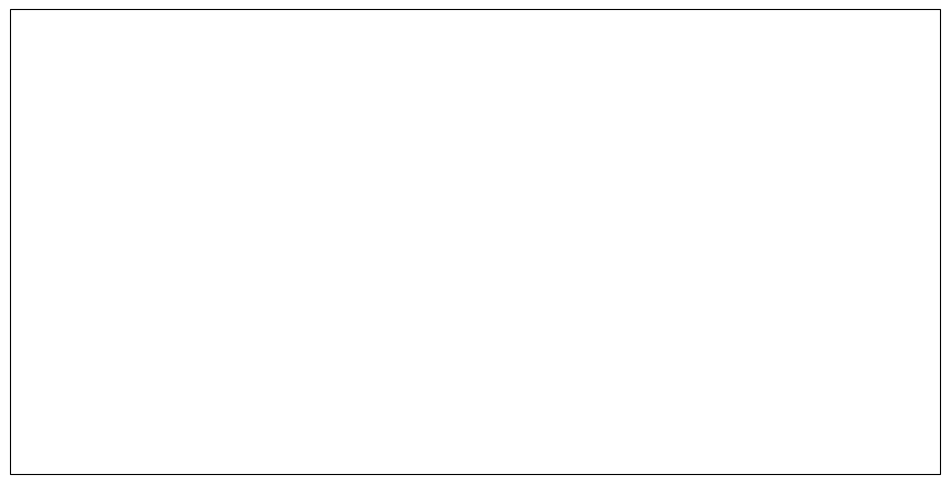

In [41]:
plot_map(t2m_wind_10m.t2m, 'Hi')